<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2017-10-19 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.20.1
sklearn 0.19.0
mlxtend 0.7.0


# Energy reconstruction via ML regression
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Weight simulation events to spectrum](#Weight-simulation-events-to-spectrum)
3. [S125 verification](#S125-verification)
4. [$\log_{10}(\mathrm{dE/dX})$ verification](#$\log_{10}(\mathrm{dE/dX})$-verification)

In [2]:
from __future__ import division, print_function
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import seaborn.apionly as sns
import dask
from dask import delayed, multiprocessing
from dask.diagnostics import ProgressBar
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (validation_curve, cross_val_score,
                                     cross_val_predict, GridSearchCV, 
                                     cross_validate, KFold)
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, make_scorer

import comptools as comp
import comptools.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

## Define analysis parameters and load simulation

In [45]:
# feature_list = ['lap_cos_zenith', 'log_s125']
# feature_list = ['log_s80', 'log_s125', 'log_s250', 'lap_cos_zenith',
#                 'FractionContainment_Laputop_IceTop', 'NStations']

feature_list = ['log_s50', 'log_s125', 'log_s180', 'lap_cos_zenith', 'NStations', 'log_dEdX', 'InIce_charge_1_60']
feature_labels = ['$\mathrm{\log_{10}(S_{50})}$', '$\mathrm{\log_{10}(S_{125})}$', '$\mathrm{\log_{10}(S_{180})}$', 
                  '$\mathrm{\cos(\\theta)}$', 'NStations', '$\mathrm{\log_{10}(dE/dX)}$']

# config = 'IC86.2012'
config = 'IC79.2010'
num_groups = 2
comp_list = comp.get_comp_list(num_groups=num_groups)
# feature_list, feature_labels = comp.get_training_features()
pipeline_str = 'RF_energy_{}'.format(config)
energybins = comp.analysis.get_energybins()

In [39]:
df_sim_train.columns

Index([u'FractionContainment_Laputop_IceTop',
       u'FractionContainment_Laputop_InIce',
       u'FractionContainment_MCPrimary_IceTop',
       u'FractionContainment_MCPrimary_InIce', u'IceTopMaxSignal',
       u'IceTopMaxSignalInEdge', u'IceTopMaxSignalString',
       u'IceTopNeighbourMaxSignal', u'InIce_charge_1_60', u'MC_azimuth',
       u'MC_comp', u'MC_comp_class', u'MC_energy', u'MC_type', u'MC_x',
       u'MC_y', u'MC_zenith', u'NChannels_1_60', u'NHits_1_60', u'NStations',
       u'StationDensity', u'angle_MCPrimary_Laputop', u'avg_inice_radius',
       u'd4r_N', u'd4r_b', u'd4r_exists', u'd4r_gamma', u'd4r_mean',
       u'd4r_median', u'd4r_peak_energy', u'd4r_peak_sigma',
       u'eloss_1500_standard', u'end_time_mjd',
       u'frac_outside_one_std_inice_radius',
       u'frac_outside_two_std_inice_radius', u'lap_azimuth', u'lap_beta',
       u'lap_chi2', u'lap_energy', u'lap_fitstatus_ok', u'lap_ndf',
       u'lap_rlogl', u'lap_s125', u'lap_s180', u'lap_s250', u'lap_s50',


In [40]:
feature_list

['log_s50', 'log_s125', 'log_s180', 'lap_cos_zenith', 'NStations', 'log_dEdX']

In [5]:
df_sim_train, df_sim_test = comp.load_sim(config=config, log_energy_min=5.0, log_energy_max=None)

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['lap_log_energy'] = np.nan_to_num(np.log10(df['lap_energy']))
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['InIce_log_charge_'+i] = np.log10(df['InIce_charge_'+i])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [6]:
df_sim_train.MC_log_energy.max(), df_sim_train.reco_log_energy.max()

(9.4998322600377367, 9.4655614394323795)

Construct composition masking array for testing and training sets

In [7]:
comp_mask_train, comp_mask_test = {}, {}
for composition in comp_list:
    comp_mask_train[composition] = df_sim_train['comp_group_{}'.format(num_groups)] == composition
    comp_mask_test[composition] = df_sim_test['comp_group_{}'.format(num_groups)] == composition

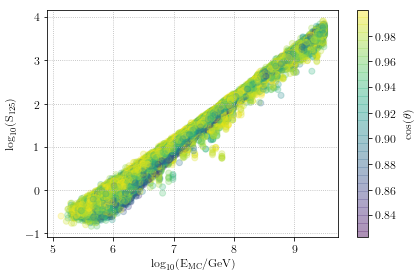

In [49]:
fig, ax = plt.subplots()
sc = ax.scatter(df_sim_train['MC_log_energy'], df_sim_train['log_s125'],
                c=df_sim_train['lap_cos_zenith'], alpha=0.25)
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
plt.colorbar(sc, label='$\mathrm{\cos(\\theta)}$')
s125_vs_MC_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         's125_vs_MC_energy_zenith.png')
comp.check_output_dir(s125_vs_MC_energy_outfile)
# plt.savefig(s125_vs_MC_energy_outfile)
plt.show()

## Explore energy reconstruction training features 

$\mathrm{\log_{10}(S_{125})}$ is highly correlated with true energy, and only has a slight composition dependence. This makes it an important training feature in energy reconstruction. 

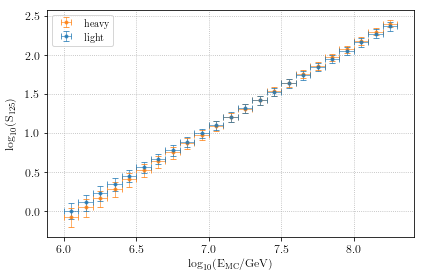

In [52]:
fig, ax = plt.subplots()
for composition in comp_list:
    log_s125 = df_sim_train.loc[comp_mask_train[composition], 'log_s125']
    MC_log_energy = df_sim_train.loc[comp_mask_train[composition], 'MC_log_energy']

    _, bin_medians, error = comp.analysis.get_medians(MC_log_energy, log_s125,
                                                      energybins.log_energy_bins)
    ax.errorbar(energybins.log_energy_midpoints, bin_medians, yerr=error, xerr=0.05, 
                marker='.', ls='None', label=composition, color=color_dict[composition], alpha=0.75)
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
ax.grid()
ax.legend()
plt.show()

$\mathrm{\log_{10}(dE/dX)}$ too is correlated with true energy, but has the added benefit of being composition dependent as well. This means that an energy reconstruction regressor can also learn composition-dependence of __________.

In [24]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], df_sim_test['log_dEdX'],
                                    bins=[np.linspace(6.0, 8.0, 100), np.linspace(-0.5, 3, 100)])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

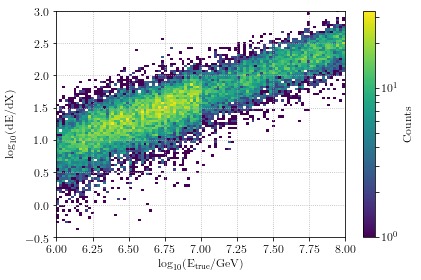

In [25]:
fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(dE/dX)}$')
ax.grid()
plt.colorbar(label='Counts')
# true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
#                                          'MC_vs_reco_energy.png')
# comp.check_output_dir(true_vs_reco_energy_outfile)
# plt.savefig(true_vs_reco_energy_outfile)
plt.show()

## Train a RandomForestRegressor to predict shower energy

Define scoring function

In [ ]:
def median_energy_res(log_energy, log_energy_pred):
    return np.median(log_energy-log_energy_pred)
scorer = make_scorer(median_energy_res, greater_is_better=False)

In [ ]:
# parameters = {'max_depth': np.arange(1, 11), 'n_estimators': np.arange(1, 100, 10)}
# gs = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error',
#                   cv=10, n_jobs=10, verbose=2)

# # parameters = {'C': np.linspace(0.01, 1, 10)}
# # gs = GridSearchCV(SVR(), parameters, cv=10, n_jobs=10, verbose=2)

In [ ]:
# gs.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy'])
# gs.best_params_

In [ ]:
# cv_results = pd.DataFrame(gs.cv_results_)

In [6]:
# # clf = gs.best_estimator_
# pipeline_str = 'RF_energy'
# pipeline = comp.get_pipeline(pipeline_str)
# pipeline

Pipeline(memory=None,
     steps=[('classifier', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
           oob_score=False, random_state=2, verbose=0, warm_start=False))])

In [8]:
# clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=2)
# clf = RandomForestRegressor(n_estimators=100, n_jobs=10, random_state=2)

In [9]:
cv_results = cross_validate(pipeline, df_sim_train[feature_list], df_sim_train['MC_log_energy'], 
                            cv=10, verbose=2)

[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s
[CV]  ................................................................
[CV] ................................................. , total=   2.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


In [20]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
train_score_mean = np.mean(cv_results['train_score'])
train_score_std = np.std(cv_results['train_score'])
print('Training score = {:0.3f} +/- {:0.2e}'.format(train_score_mean, train_score_std))
test_score_mean = np.mean(cv_results['test_score'])
test_score_std = np.std(cv_results['test_score'])
print('Testing score = {:0.3f} +/- {:0.2e}'.format(test_score_mean, test_score_std))
print('=' * 30)

RandomForestRegressor
Training score = 0.990 +/- 1.24e-04
Testing score = 0.987 +/- 3.78e-04


In [46]:
pipeline = comp.get_pipeline(pipeline_str)
pipeline.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy'])
reco_log_energy = pipeline.predict(df_sim_test[feature_list])

In [47]:
reco_log_energy

array([ 7.81391385,  6.96376353,  7.04519393, ...,  7.69846225,
        7.70630025,  6.74139987])

In [48]:
reco_log_energy.max()

9.4749897984418165

1) 0.994364704285
2) 0.00348824930784
3) 0.00214704640735


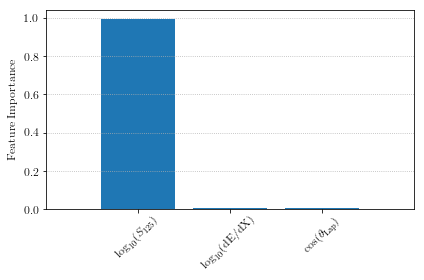

In [71]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

ax.set_ylabel('Feature Importance')
ax.bar(range(num_features), importances[indices], align='center')
plt.xticks(range(num_features), np.array(feature_labels)[indices], rotation=45)
ax.set_xlim([-1, len(feature_list)])
ax.grid(axis='y')
plt.show()

## Model validation

In [47]:
parameters = {'classifier__max_depth': np.arange(1, 16, dtype=int), 
              'classifier__n_estimators': np.arange(10, 320, 20, dtype=int)}

# parameters = {'classifier__max_depth': range(1, 8), 
#               'classifier__n_estimators':[5, 10, 20, 50, 100, 200, 300, 400, 500, 600]}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=10, verbose=2)
grid_search.fit(df_sim_train[feature_list], df_sim_train['MC_log_energy']);

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV] classifier__n_estimators=10, classifier__max_depth=1 ............
[CV] classifier__n_estimators=30, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=30, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=30, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=1, total=   0.3s
[CV] classifier__n_estimators=50, classifier__max_depth=1 ............
[CV] classifier__n_estimators=50, classifier__max_depth=1 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=1, total=   0.5s
[CV] classifier__n_estimators=50, classifier__max_depth=1 ............
[C

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    4.0s


[CV] classifier__n_estimators=190, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=1, total=   1.1s
[CV] classifier__n_estimators=190, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=1, total=   1.2s
[CV] classifier__n_estimators=210, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=1, total=   1.0s
[CV] classifier__n_estimators=210, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=1, total=   1.1s
[CV] classifier__n_estimators=210, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=230, classifier__max_depth=1 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=1, total=   1.4s
[CV]  classifier__n_estimators=170, classifier__max_depth=1, total=   1.4s
[CV] classifier__n_estimators=230, classifier__max_depth=1 ...........
[CV] classifier__n_estimators=230, classifier__max_de

[CV]  classifier__n_estimators=190, classifier__max_depth=2, total=   2.1s
[CV] classifier__n_estimators=250, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=190, classifier__max_depth=2, total=   2.2s
[CV] classifier__n_estimators=270, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=210, classifier__max_depth=2, total=   2.4s
[CV] classifier__n_estimators=270, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=210, classifier__max_depth=2, total=   2.5s
[CV]  classifier__n_estimators=210, classifier__max_depth=2, total=   2.5s
[CV]  classifier__n_estimators=230, classifier__max_depth=2, total=   2.4s
[CV]  classifier__n_estimators=230, classifier__max_depth=2, total=   2.7s
[CV]  classifier__n_estimators=230, classifier__max_depth=2, total=   2.4s
[CV] classifier__n_estimators=270, classifier__max_depth=2 ...........
[CV] classifier__n_estimators=290, classifier__max_depth=2 ...........
[CV]  classifier__n_estimators=250, classifie

[CV] classifier__n_estimators=310, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=3 ...........
[CV] classifier__n_estimators=310, classifier__max_depth=3 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=3, total=   2.8s
[CV] classifier__n_estimators=10, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=4, total=   0.7s
[CV]  classifier__n_estimators=270, classifier__max_depth=3, total=   3.3s
[CV]  classifier__n_estimators=270, classifier__max_depth=3, total=   3.2s
[CV] classifier__n_estimators=10, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=270, classifier__max_depth=3, total=   3.9s
[CV] classifier__n_estimators=10, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=10, classifier__max_depth=4, total=   0.4s
[CV]  classifier__n_estimators=290, classifier__max_depth=3, total=   4.0s
[CV] classifier__n_estimators=30, classifier__max_d

[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   38.8s


[CV] classifier__n_estimators=30, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=290, classifier__max_depth=3, total=   4.5s
[CV] classifier__n_estimators=50, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=4, total=   0.6s
[CV]  classifier__n_estimators=310, classifier__max_depth=3, total=   4.3s
[CV] classifier__n_estimators=50, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=310, classifier__max_depth=3, total=   4.2s
[CV]  classifier__n_estimators=310, classifier__max_depth=3, total=   4.8s
[CV] classifier__n_estimators=50, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=30, classifier__max_depth=4, total=   0.6s
[CV]  classifier__n_estimators=30, classifier__max_depth=4, total=   0.5s
[CV] classifier__n_estimators=70, classifier__max_depth=4 ............
[CV]  classifier__n_estimators=50, classifier__max_depth=4, total=   0.7s
[CV]  classifier__n_estimators=50, classifier__ma

[CV] classifier__n_estimators=90, classifier__max_depth=5 ............
[CV] classifier__n_estimators=90, classifier__max_depth=5 ............
[CV]  classifier__n_estimators=70, classifier__max_depth=5, total=   1.1s
[CV] classifier__n_estimators=90, classifier__max_depth=5 ............
[CV] classifier__n_estimators=110, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=70, classifier__max_depth=5, total=   1.0s
[CV] classifier__n_estimators=110, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=70, classifier__max_depth=5, total=   1.1s
[CV] classifier__n_estimators=110, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=90, classifier__max_depth=5, total=   1.3s
[CV]  classifier__n_estimators=90, classifier__max_depth=5, total=   1.2s
[CV]  classifier__n_estimators=110, classifier__max_depth=5, total=   1.5s
[CV] classifier__n_estimators=130, classifier__max_depth=5 ...........
[CV]  classifier__n_estimators=90, classifier__max_depth=5

[CV] classifier__n_estimators=150, classifier__max_depth=6 ...........
[CV] classifier__n_estimators=170, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=110, classifier__max_depth=6, total=   2.7s
[CV] classifier__n_estimators=170, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=90, classifier__max_depth=6, total=   4.9s
[CV] classifier__n_estimators=170, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=110, classifier__max_depth=6, total=   3.4s
[CV]  classifier__n_estimators=130, classifier__max_depth=6, total=   2.9s
[CV] classifier__n_estimators=190, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=6, total=   3.0s
[CV] classifier__n_estimators=190, classifier__max_depth=6 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=6, total=   3.5s
[CV] classifier__n_estimators=190, classifier__max_depth=6 ...........
[CV] classifier__n_estimators=210, classifier__max_dep

[CV] classifier__n_estimators=210, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=7, total=   7.5s
[CV]  classifier__n_estimators=170, classifier__max_depth=7, total=   6.3s
[CV] classifier__n_estimators=230, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=7, total=   9.1s
[CV] classifier__n_estimators=230, classifier__max_depth=7 ...........
[CV] classifier__n_estimators=230, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=210, classifier__max_depth=7, total=   7.0s
[CV] classifier__n_estimators=250, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=190, classifier__max_depth=7, total=   8.9s
[CV] classifier__n_estimators=250, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=190, classifier__max_depth=7, total=  11.9s
[CV] classifier__n_estimators=250, classifier__max_depth=7 ...........
[CV]  classifier__n_estimators=230, classifier__max_d

[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  2.6min


[CV]  classifier__n_estimators=90, classifier__max_depth=8, total=   2.9s
[CV]  classifier__n_estimators=90, classifier__max_depth=8, total=   2.5s
[CV] classifier__n_estimators=130, classifier__max_depth=8 ...........
[CV]  classifier__n_estimators=110, classifier__max_depth=8, total=   2.0s
[CV]  classifier__n_estimators=50, classifier__max_depth=8, total=   6.4s
[CV] classifier__n_estimators=130, classifier__max_depth=8 ...........
[CV] classifier__n_estimators=150, classifier__max_depth=8 ...........
[CV] classifier__n_estimators=150, classifier__max_depth=8 ...........
[CV]  classifier__n_estimators=110, classifier__max_depth=8, total=   3.7s
[CV] classifier__n_estimators=150, classifier__max_depth=8 ...........
[CV]  classifier__n_estimators=130, classifier__max_depth=8, total=   1.7s
[CV] classifier__n_estimators=170, classifier__max_depth=8 ...........
[CV]  classifier__n_estimators=90, classifier__max_depth=8, total=   5.2s
[CV] classifier__n_estimators=170, classifier__max_de

[CV] classifier__n_estimators=190, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=9, total=   3.2s
[CV] classifier__n_estimators=190, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=9, total=   4.1s
[CV] classifier__n_estimators=190, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=110, classifier__max_depth=9, total=   9.3s
[CV] classifier__n_estimators=210, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=270, classifier__max_depth=8, total=  33.0s
[CV] classifier__n_estimators=210, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=150, classifier__max_depth=9, total=   7.9s
[CV] classifier__n_estimators=210, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=170, classifier__max_depth=9, total=   5.5s
[CV] classifier__n_estimators=230, classifier__max_depth=9 ...........
[CV]  classifier__n_estimators=190, classifier__max_d

[CV]  classifier__n_estimators=190, classifier__max_depth=10, total=   6.6s
[CV]  classifier__n_estimators=190, classifier__max_depth=10, total=   6.2s
[CV]  classifier__n_estimators=150, classifier__max_depth=10, total=  11.5s
[CV]  classifier__n_estimators=150, classifier__max_depth=10, total=  11.0s
[CV] classifier__n_estimators=250, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=250, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=250, classifier__max_depth=10 ..........
[CV] classifier__n_estimators=270, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=210, classifier__max_depth=10, total=   7.6s
[CV] classifier__n_estimators=270, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=210, classifier__max_depth=10, total=   7.0s
[CV] classifier__n_estimators=270, classifier__max_depth=10 ..........
[CV]  classifier__n_estimators=210, classifier__max_depth=10, total=   7.1s
[CV] classifier__n_estimators=290, classif

[CV] classifier__n_estimators=290, classifier__max_depth=11 ..........
[CV] classifier__n_estimators=290, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=250, classifier__max_depth=11, total=   8.4s
[CV] classifier__n_estimators=310, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=230, classifier__max_depth=11, total=  14.6s
[CV] classifier__n_estimators=310, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=270, classifier__max_depth=11, total=   7.9s
[CV] classifier__n_estimators=310, classifier__max_depth=11 ..........
[CV]  classifier__n_estimators=250, classifier__max_depth=11, total=  10.8s
[CV] classifier__n_estimators=10, classifier__max_depth=12 ...........
[CV]  classifier__n_estimators=230, classifier__max_depth=11, total=  15.4s
[CV] classifier__n_estimators=10, classifier__max_depth=12 ...........
[CV]  classifier__n_estimators=10, classifier__max_depth=12, total=   1.8s
[CV] classifier__n_estimators=10, classifier__ma

[CV]  classifier__n_estimators=10, classifier__max_depth=13, total=   0.7s
[CV] classifier__n_estimators=30, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=310, classifier__max_depth=12, total=   8.0s
[CV] classifier__n_estimators=30, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=10, classifier__max_depth=13, total=   1.2s
[CV]  classifier__n_estimators=290, classifier__max_depth=12, total=  12.0s
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=30, classifier__max_depth=13, total=   1.5s
[CV]  classifier__n_estimators=30, classifier__max_depth=13, total=   1.7s
[CV] classifier__n_estimators=50, classifier__max_depth=13 ...........
[CV] classifier__n_estimators=70, classifier__max_depth=13 ...........
[CV]  classifier__n_estimators=250, classifier__max_depth=12, total=  20.9s
[CV] classifier__n_estimators=70, classifier__

[CV]  classifier__n_estimators=270, classifier__max_depth=13, total=  24.7s
[CV] classifier__n_estimators=90, classifier__max_depth=14 ...........
[CV]  classifier__n_estimators=50, classifier__max_depth=14, total=   5.8s
[CV] classifier__n_estimators=90, classifier__max_depth=14 ...........
[CV]  classifier__n_estimators=290, classifier__max_depth=13, total=  14.1s
[CV]  classifier__n_estimators=270, classifier__max_depth=13, total=  24.7s
[CV] classifier__n_estimators=90, classifier__max_depth=14 ...........


[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  6.7min


[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=50, classifier__max_depth=14, total=   3.9s
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=310, classifier__max_depth=13, total=  12.5s
[CV]  classifier__n_estimators=70, classifier__max_depth=14, total=   4.2s
[CV]  classifier__n_estimators=50, classifier__max_depth=14, total=   4.5s
[CV] classifier__n_estimators=110, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=130, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=70, classifier__max_depth=14, total=   2.6s
[CV] classifier__n_estimators=130, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=70, classifier__max_depth=14, total=   3.5s
[CV] classifier__n_estimators=130, classifier__max_depth=14 ..........
[CV] classifier__n_estimators=150, classifier__max_depth=14 ..........
[CV]  classifier__n_estimators=90, classifier__max_d

[CV] classifier__n_estimators=150, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=110, classifier__max_depth=15, total=   4.3s
[CV] classifier__n_estimators=170, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=110, classifier__max_depth=15, total=   4.1s
[CV] classifier__n_estimators=170, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=150, classifier__max_depth=15, total=   4.5s
[CV] classifier__n_estimators=170, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=110, classifier__max_depth=15, total=   7.0s
[CV] classifier__n_estimators=190, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=90, classifier__max_depth=15, total=   8.4s
[CV]  classifier__n_estimators=130, classifier__max_depth=15, total=   6.0s
[CV] classifier__n_estimators=190, classifier__max_depth=15 ..........
[CV] classifier__n_estimators=190, classifier__max_depth=15 ..........
[CV]  classifier__n_estimators=130, classifier__

[Parallel(n_jobs=10)]: Done 720 out of 720 | elapsed:  8.5min finished


In [48]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.columns

Index([u'mean_fit_time', u'mean_score_time', u'mean_test_score',
       u'mean_train_score', u'param_classifier__max_depth',
       u'param_classifier__n_estimators', u'params', u'rank_test_score',
       u'split0_test_score', u'split0_train_score', u'split1_test_score',
       u'split1_train_score', u'split2_test_score', u'split2_train_score',
       u'std_fit_time', u'std_score_time', u'std_test_score',
       u'std_train_score'],
      dtype='object')

In [49]:
pivot_test_score = cv_results.pivot("param_classifier__max_depth", "param_classifier__n_estimators", "mean_test_score")
pivot_test_score

param_classifier__n_estimators,10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,310
param_classifier__max_depth,,,,,,,,,,,,,,,,
1,0.699301,0.700558,0.702758,0.702971,0.702982,0.702663,0.703007,0.703098,0.703124,0.702739,0.702678,0.702362,0.702626,0.702773,0.702636,0.702674
2,0.915339,0.915999,0.916904,0.917297,0.917355,0.917188,0.917411,0.917406,0.917347,0.917307,0.917287,0.917180,0.917265,0.917315,0.917249,0.917336
3,0.967083,0.967695,0.968043,0.968256,0.968297,0.968257,0.968355,0.968351,0.968330,0.968301,0.968309,0.968267,0.968309,0.968327,0.968323,0.968361
4,0.978557,0.978905,0.979041,0.979100,0.979116,0.979105,0.979139,0.979141,0.979131,0.979120,0.979121,0.979105,0.979120,0.979121,0.979123,0.979087
5,0.982727,0.983046,0.983105,0.983128,0.983141,0.983144,0.983161,0.983155,0.983147,0.983148,0.983149,0.983144,0.983151,0.983150,0.983146,0.983159
6,0.985180,0.985378,0.985435,0.985447,0.985458,0.985369,0.985427,0.985465,0.985430,0.985464,0.985462,0.985463,0.985403,0.985465,0.985460,0.985466
7,0.986402,0.986521,0.986597,0.986607,0.986608,0.986618,0.986621,0.986624,0.986596,0.986624,0.986550,0.986605,0.986587,0.986621,0.986623,0.986618
8,0.987009,0.987163,0.987183,0.986985,0.987195,0.987195,0.987198,0.987198,0.987199,0.987192,0.987201,0.987202,0.987164,0.987200,0.987202,0.987196
9,0.987198,0.987362,0.987380,0.987387,0.987357,0.987314,0.987397,0.987399,0.987363,0.987403,0.987406,0.987407,0.987386,0.987409,0.987356,0.987409


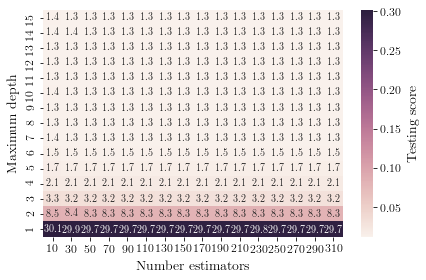

In [56]:
# Draw a heatmap with the numeric values in each cell
fig, ax = plt.subplots()
sns.heatmap(1-pivot_test_score, annot=True, fmt='0.1%', ax=ax,
            cbar_kws={"label": "Testing score"}, robust=False, square=False)

# for _, spine in ax.spines.items():
#     spine.set_visible(True)
    
ax.set_xlabel('Number estimators')
ax.set_ylabel('Maximum depth')
ax.invert_yaxis()

outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation',
                       'grid-search-max_depth-n_estimators-heatmap.png')
# plt.savefig(outfile)
plt.show()

In [16]:
@delayed
def _cross_validate_comp(df_train, df_test, pipeline_str, param_name, param_value,
                         feature_list=None, target='comp_target_2', scoring='r2', 
                         num_groups=2, n_splits=10):
    '''Calculates stratified k-fold CV scores for a given hyperparameter value

    Parameters
    ----------
    config : str
        Detector configuration.
    pipeline_str : str
        Name of pipeline to use (e.g. 'BDT', 'RF_energy', etc.).
    param_name : str
        Name of hyperparameter (e.g. 'max_depth', 'learning_rate', etc.).
    param_value : int, float, str
        Value to set hyperparameter to.
    feature_list : list, optional
        List of training feature columns to use (default is to use 
        comptools.get_training_features()). 
    target : str, optional
        Training target to use (default is 'comp_target_2').
    scoring : {'r2', 'mse', 'accuracy'}
        Scoring metric to calculate for each CV fold (default is 'r2'). 
    num_groups : int, optional
        Number of composition class groups to use (default is 2). 
    n_splits : int, optional
        Number of folds to use in (KFold) cross-validation
        (default is 10).

    Returns
    -------
        data_dict : dict
            Return a dictionary with average scores as well as CV errors on those scores.

    '''
    assert scoring in ['accuracy', 'mse', 'r2'], 'Invalid scoring parameter'
    comp_list = comp.get_comp_list(num_groups=num_groups)
    if feature_list is None:
        feature_list, _ = comp.get_training_features()
        
    pipeline = comp.get_pipeline(pipeline_str)
    pipeline.named_steps['classifier'].set_params(**{param_name: param_value})
    # Only run on a single core
    pipeline.named_steps['classifier'].set_params(**{'n_jobs': 1})

    data_dict = {'classifier': pipeline_str, 'param_name': param_name,
                 'param_value': param_value, 'n_splits': n_splits}

    train_scores = defaultdict(list)
    test_scores = defaultdict(list)
    ks_pval = defaultdict(list)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2)
    if scoring == 'mse':
        scorer = mean_squared_error
    elif scoring == 'r2':
        scorer = r2_score
    else:
        scorer = accuracy_score

    for train_index, test_index in kf.split(df_train.values):

        df_train_fold, df_test_fold = df_train.iloc[train_index], df_train.iloc[test_index]

        X_train, y_train = comp.dataframe_functions.dataframe_to_X_y(df_train_fold, feature_list, target=target)
        X_test, y_test = comp.dataframe_functions.dataframe_to_X_y(df_test_fold, feature_list, target=target)

        pipeline = pipeline.fit(X_train, y_train)

        train_pred = pipeline.predict(X_train)
        train_score = scorer(y_train, train_pred)
        train_scores['total'].append(train_score)

        test_pred = pipeline.predict(X_test)
        test_score = scorer(y_test, test_pred)
        test_scores['total'].append(test_score)

        # Get testing/training scores for each composition group
        for composition in comp_list:
            comp_mask_train = df_train_fold['comp_group_{}'.format(num_groups)] == composition
            comp_score_train = scorer(y_train[comp_mask_train], train_pred[comp_mask_train])
            train_scores[composition].append(comp_score_train)

            comp_mask_test = df_test_fold['comp_group_{}'.format(num_groups)] == composition
            comp_score_test = scorer(y_test[comp_mask_test], test_pred[comp_mask_test])
            test_scores[composition].append(comp_score_test)


    for label in comp_list + ['total']:
        data_dict['train_mean_{}'.format(label)] = np.mean(train_scores[label])
        data_dict['train_std_{}'.format(label)] = np.std(train_scores[label])
        data_dict['test_mean_{}'.format(label)] = np.mean(test_scores[label])
        data_dict['test_std_{}'.format(label)] = np.std(test_scores[label])

    return data_dict

In [17]:
def cross_validate_comp(df_train, df_test, pipeline_str, 
                        param_name, param_values,
                        feature_list=None, target='comp_target_2', 
                        scoring='r2', num_groups=2, n_splits=10, n_jobs=1,
                        verbose=False):
    cv_dicts = []
    for param_value in param_values:
        cv_dict = _cross_validate_comp(
                    df_train, df_test, pipeline_str, 
                    param_name, param_value,
                    feature_list=feature_list, target=target, 
                    scoring=scoring, num_groups=num_groups, n_splits=10)
        cv_dicts.append(cv_dict)

    df_cv = delayed(pd.DataFrame.from_records)(cv_dicts, index='param_value')
    
    get = dask.get if n_jobs == 1 else multiprocessing.get
    if verbose:
        with ProgressBar():
            print('Performing {}-fold CV on {} hyperparameter values ({} fits):'.format(
                n_splits, len(param_values),  n_splits*len(param_values)))
            df_cv = df_cv.compute(get=get, num_works=n_jobs)
#             df_cv = df_cv.compute(num_works=n_jobs)
    else:
        df_cv = df_cv.compute(get=get, num_works=n_jobs)
    
    return df_cv

In [26]:
max_depth_values = np.arange(1, 16, dtype=int)
df_cv_max_depth = comp.cross_validate_comp(
                            df_sim_train, df_sim_test, pipeline_str, 
                            param_name='max_depth', param_values=max_depth_values,
                            feature_list=feature_list, target='MC_log_energy', 
                            scoring='mse', num_groups=num_groups, n_splits=10,
                            verbose=True, n_jobs=10)
#                             verbose=True, n_jobs=min(len(param_values), 20))

Performing 10-fold CV on 15 hyperparameter values (150 fits):
[########################################] | 100% Completed | 18min 49.3s


In [28]:
df_cv_max_depth

,classifier,n_splits,param_name,test_mean_heavy,test_mean_light,test_mean_total,test_std_heavy,test_std_light,test_std_total,train_mean_heavy,train_mean_light,train_mean_total,train_std_heavy,train_std_light,train_std_total
param_value,,,,,,,,,,,,,,,
1,RF_energy_IC79.2010,10,max_depth,0.196084,0.204134,0.200264,0.002554,0.004331,0.002565,0.196037,0.204114,0.200224,0.000282,0.000461,0.000262
2,RF_energy_IC79.2010,10,max_depth,0.057752,0.058675,0.058230,0.000720,0.000734,0.000589,0.057710,0.058620,0.058182,0.000117,0.000110,0.000107
3,RF_energy_IC79.2010,10,max_depth,0.017456,0.018632,0.018066,0.000244,0.000240,0.000184,0.017419,0.018582,0.018022,0.000075,0.000056,0.000064
4,RF_energy_IC79.2010,10,max_depth,0.007987,0.008832,0.008425,0.000156,0.000129,0.000126,0.007945,0.008781,0.008378,0.000041,0.000037,0.000038
5,RF_energy_IC79.2010,10,max_depth,0.005100,0.006324,0.005735,0.000135,0.000132,0.000118,0.005055,0.006268,0.005684,0.000023,0.000026,0.000024
6,RF_energy_IC79.2010,10,max_depth,0.004069,0.005303,0.004709,0.000105,0.000134,0.000104,0.004014,0.005236,0.004647,0.000015,0.000016,0.000013
7,RF_energy_IC79.2010,10,max_depth,0.003442,0.004883,0.004189,0.000076,0.000138,0.000092,0.003367,0.004788,0.004104,0.000011,0.000013,0.000010
8,RF_energy_IC79.2010,10,max_depth,0.003094,0.004611,0.003881,0.000068,0.000134,0.000081,0.002990,0.004456,0.003750,0.000007,0.000014,0.000008
9,RF_energy_IC79.2010,10,max_depth,0.002898,0.004452,0.003703,0.000065,0.000131,0.000074,0.002744,0.004177,0.003487,0.000007,0.000012,0.000007


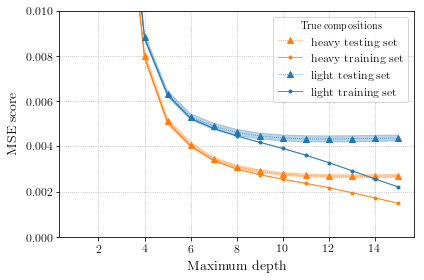

In [30]:
fig, ax = plt.subplots()
# for composition in comp_list + ['total']:
for composition in comp_list:
    # Plot testing curve
    ax.plot(df_cv_max_depth.index, df_cv_max_depth['test_mean_{}'.format(composition)],
            marker='^', ls=':', color=color_dict[composition], label=composition+' testing set')
    test_err_high = df_cv_max_depth['test_mean_{}'.format(composition)] + df_cv_max_depth['test_std_{}'.format(composition)]
    test_err_low = df_cv_max_depth['test_mean_{}'.format(composition)] - df_cv_max_depth['test_std_{}'.format(composition)]
    ax.fill_between(df_cv_max_depth.index, test_err_high, test_err_low,
                    color=color_dict[composition], alpha=0.3)
    
    # Plot training curve
    ax.plot(df_cv_max_depth.index, df_cv_max_depth['train_mean_{}'.format(composition)],
            marker='.', ls='-', color=color_dict[composition], label=composition+' training set')
    train_err_high = df_cv_max_depth['train_mean_{}'.format(composition)] + df_cv_max_depth['train_std_{}'.format(composition)]
    train_err_low = df_cv_max_depth['train_mean_{}'.format(composition)] - df_cv_max_depth['train_std_{}'.format(composition)]
    ax.fill_between(df_cv_max_depth.index, train_err_high, train_err_low,
                    color=color_dict[composition], alpha=0.3)
    
ax.set_xlabel('Maximum depth')
# ax.set_ylabel('R$^2$ CV score')
ax.set_ylabel('MSE score')
# ax.set_ylim(0.95, 1.0)
ax.set_ylim(0, 0.01)
ax.grid()
ax.legend(title='True compositions')
max_depth_outfile = os.path.join(comp.paths.figures_dir, 'model_evaluation', 'validation-curves',
                                 '{}_max_depth_{}.png'.format(pipeline_str, config))
comp.check_output_dir(max_depth_outfile)
# plt.savefig(max_depth_outfile)
plt.show()

In [21]:
param_values = np.arange(10, 320, 20, dtype=int)
df_cv_n_estimators = cross_validate_comp(
# df_cv_max_depth = comp.analysis.modelevaluation.cross_validate_comp(
                            df_sim_train, df_sim_test, pipeline_str, 
                            param_name='n_estimators', param_values=param_values,
                            feature_list=feature_list, target='MC_log_energy', 
                            scoring='mse', num_groups=num_groups, n_splits=10,
                            verbose=True, n_jobs=10)
#                             verbose=True, n_jobs=min(len(param_values), 20))

Performing 10-fold CV on 16 hyperparameter values (160 fits):
[########################################] | 100% Completed |  4min 50.9s


In [22]:
df_cv_n_estimators

,classifier,n_splits,param_name,test_mean_heavy,test_mean_light,test_mean_total,test_std_heavy,test_std_light,test_std_total,train_mean_heavy,train_mean_light,train_mean_total,train_std_heavy,train_std_light,train_std_total
param_value,,,,,,,,,,,,,,,
10,RF_energy_IC86.2012,10,n_estimators,0.003910,0.005214,0.004589,0.000102,0.000278,0.000151,0.003721,0.004990,0.004382,0.000030,0.000023,0.000013
30,RF_energy_IC86.2012,10,n_estimators,0.003883,0.005177,0.004557,0.000110,0.000278,0.000156,0.003682,0.004953,0.004344,0.000024,0.000022,0.000015
50,RF_energy_IC86.2012,10,n_estimators,0.003873,0.005175,0.004551,0.000103,0.000276,0.000150,0.003675,0.004946,0.004337,0.000019,0.000023,0.000013
70,RF_energy_IC86.2012,10,n_estimators,0.003872,0.005172,0.004549,0.000106,0.000277,0.000152,0.003673,0.004945,0.004336,0.000015,0.000024,0.000011
90,RF_energy_IC86.2012,10,n_estimators,0.003868,0.005171,0.004547,0.000106,0.000277,0.000152,0.003671,0.004942,0.004333,0.000015,0.000023,0.000011
110,RF_energy_IC86.2012,10,n_estimators,0.003868,0.005171,0.004547,0.000107,0.000275,0.000151,0.003670,0.004942,0.004333,0.000015,0.000023,0.000012
130,RF_energy_IC86.2012,10,n_estimators,0.003868,0.005172,0.004547,0.000106,0.000277,0.000154,0.003670,0.004941,0.004332,0.000015,0.000023,0.000012
150,RF_energy_IC86.2012,10,n_estimators,0.003869,0.005172,0.004548,0.000106,0.000277,0.000153,0.003670,0.004942,0.004333,0.000014,0.000022,0.000011
170,RF_energy_IC86.2012,10,n_estimators,0.003869,0.005172,0.004547,0.000106,0.000276,0.000153,0.003670,0.004941,0.004333,0.000014,0.000023,0.000011


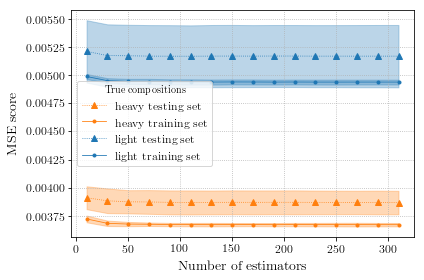

In [23]:
fig, ax = plt.subplots()
for composition in comp_list:
    # Plot testing curve
    ax.plot(df_cv_n_estimators.index, df_cv_n_estimators['test_mean_{}'.format(composition)],
            marker='^', ls=':', color=color_dict[composition], label=composition+' testing set')
    test_err_high = df_cv_n_estimators['test_mean_{}'.format(composition)] + df_cv_n_estimators['test_std_{}'.format(composition)]
    test_err_low = df_cv_n_estimators['test_mean_{}'.format(composition)] - df_cv_n_estimators['test_std_{}'.format(composition)]
    ax.fill_between(df_cv_n_estimators.index, test_err_high, test_err_low,
                    color=color_dict[composition], alpha=0.3)
    
    # Plot training curve
    ax.plot(df_cv_n_estimators.index, df_cv_n_estimators['train_mean_{}'.format(composition)],
            marker='.', ls='-', color=color_dict[composition], label=composition+' training set')
    train_err_high = df_cv_n_estimators['train_mean_{}'.format(composition)] + df_cv_n_estimators['train_std_{}'.format(composition)]
    train_err_low = df_cv_n_estimators['train_mean_{}'.format(composition)] - df_cv_n_estimators['train_std_{}'.format(composition)]
    ax.fill_between(df_cv_n_estimators.index, train_err_high, train_err_low,
                    color=color_dict[composition], alpha=0.3)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('MSE score')
# ax.set_ylabel('MSE testing score')
# ax.set_ylim(0, 0.01)
ax.grid()
ax.legend(title='True compositions')
plt.show()

## Energy reconstruction performance plots

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


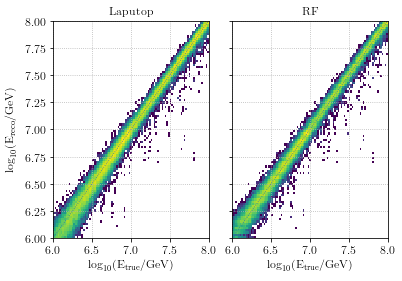

In [9]:
h_lap, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], df_sim_test['lap_log_energy'],
                                        bins=np.linspace(6.0, 8.0, 100))
h_lap = np.rot90(h_lap)
h_lap = np.flipud(h_lap)

h_reco, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], reco_log_energy,
                                         bins=np.linspace(6.0, 8.0, 100))
h_reco = np.rot90(h_reco)
h_reco = np.flipud(h_reco)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

gs = gridspec.GridSpec(1, 2, wspace=0.15)
ax_lap = plt.subplot(gs[0])
# ax_reco = plt.subplot(gs[1])
ax_reco = plt.subplot(gs[1], sharey=ax_lap)

# fig, ax = plt.subplots()
for h, ax, title in zip([h_lap, h_reco], [ax_lap, ax_reco], ['Laputop', 'RF']):
    ax.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none',
              aspect='auto')
    ax.plot([6, 8], [6, 8], marker='None', ls=':')
    # ax.set_xlim([6.4, 8.0])
    # ax.set_ylim([6.4, 8.0])
    ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
#     ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
    ax.set_title(title)
    ax.grid()
    
ax_reco.tick_params(labelleft='off')
ax_lap.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')

# plt.colorbar(label='Counts')
true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         'MC_vs_reco_energy_{}.png'.format(config))
comp.check_output_dir(true_vs_reco_energy_outfile)
plt.savefig(true_vs_reco_energy_outfile)
plt.show()

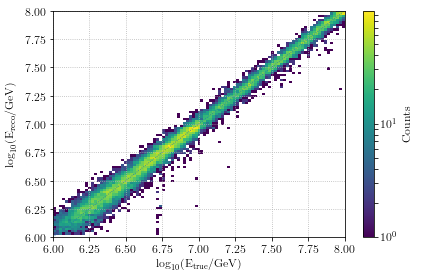

In [26]:
h, xedges, yedges  = np.histogram2d(df_sim_test['MC_log_energy'], reco_log_energy,
                                    bins=np.linspace(6.0, 8.0, 100))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
h = np.rot90(h)
h = np.flipud(h)

fig, ax = plt.subplots()
plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
ax.plot([6, 8], [6, 8], marker='None', ls=':')
# ax.set_xlim([6.4, 8.0])
# ax.set_ylim([6.4, 8.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.grid()
plt.colorbar(label='Counts')
true_vs_reco_energy_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                         'MC_vs_reco_energy.png')
comp.check_output_dir(true_vs_reco_energy_outfile)
plt.savefig(true_vs_reco_energy_outfile)
plt.show()

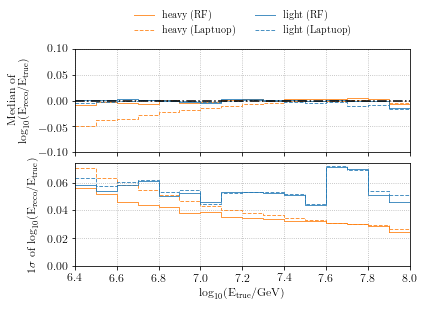

In [10]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']
log_energy_bins = np.arange(6.4, 8.1, 0.1)

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

for composition in comp_list:
#     comp_mask = df_sim_test['MC_comp_class'] == composition
    
    # Plot RF reco energy 
    medians, stds, _ = comp.analysis.get_median_std(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax1)

    plotting.plot_steps(log_energy_bins, stds, lw=1,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax2)
    
    # Plot Laputop reco energy 
    medians, stds, _ = comp.analysis.get_median_std(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                lap_energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (Laptuop)', ax=ax1)

    plotting.plot_steps(log_energy_bins, stds, lw=1, ls='--',
                        color=color_dict[composition], alpha=0.8, 
                        label=composition+' (Laptuop)', ax=ax2)

ax1.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
ax1.set_ylabel('Median of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax1.set_ylim(-0.1, 0.1)
ax1.tick_params(labelbottom='off')
ax1.grid()
# ax1.legend(title='True composition')
leg = ax1.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.45),# vertical 
                 ncol=len(comp_list), fancybox=False)

ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0)
ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax2.grid()

ax2.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_{}.png'.format(config))
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

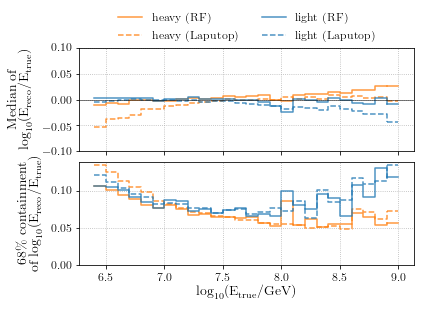

In [49]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']
log_energy_bins = np.arange(6.4, 9.1, 0.1)
# log_energy_bins = np.arange(6.4, 8.1, 0.1)

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

for composition in comp_list:
    
    # Plot RF reco energy 
    _, medians, error = comp.analysis.get_medians(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1.5,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax1)

    plotting.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1.5,
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (RF)', ax=ax2)
    
    # Plot Laputop reco energy 
    _, medians, error = comp.analysis.get_medians(
                                df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'],
                                lap_energy_res[comp_mask_test[composition]],
                                log_energy_bins)

    plotting.plot_steps(log_energy_bins, medians, lw=1.5, ls='--',
                        color=color_dict[composition], alpha=0.8,
                        label=composition+' (Laputop)', ax=ax1)

    plotting.plot_steps(log_energy_bins, np.sum(error, axis=0), lw=1.5, ls='--',
                        color=color_dict[composition], alpha=0.8, 
                        label=composition+' (Laputop)', ax=ax2)

ax1.axhline(0, marker='None', linestyle='-', color='k', lw=0.5)

ax1.set_ylabel('Median of\n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax1.set_ylim(-0.1, 0.1)
ax1.tick_params(labelbottom='off')
ax1.grid()
# ax1.legend(title='True composition')
leg = ax1.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
#                                  1.275),# vertical 
                                 1.45),# vertical 
                 ncol=len(comp_list), fancybox=False)

ax2.set_ylabel('68\% containment\nof $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0)
# ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax2.grid()

# ax2.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_compare_{}.png'.format(config))
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

In [12]:
reco_log_energy.min(), reco_log_energy.max()

(5.5794904682434039, 9.4649293863545978)

In [13]:
df_sim_test.MC_log_energy.min(), df_sim_test.MC_log_energy.max()

(5.2480956628028359, 9.4992049791454747)

In [15]:
df_sim_test.lap_log_energy.min(), df_sim_test.lap_log_energy.max()

(5.1358539936035763, 9.6503336874662615)

In [14]:
log_energy_bins

array([ 6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,
        7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,
        8.6,  8.7,  8.8,  8.9,  9. ])

KeyError: 'intermediate'

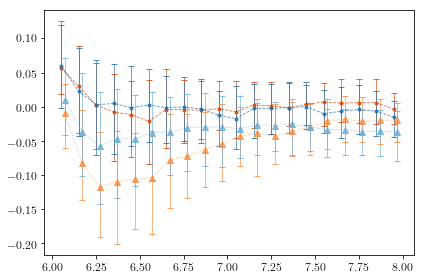

In [29]:
# Energy resolution
energy_res = reco_log_energy - df_sim_test['MC_log_energy']
lap_energy_res = df_sim_test['lap_log_energy'] - df_sim_test['MC_log_energy']


fig, ax = plt.subplots()
res_color_dict = {'light': sns.color_palette('Blues', 3).as_hex()[::-1],
                  'heavy': sns.color_palette('Oranges', 3).as_hex()[::-1]}
for composition in comp_list:
    comp_mask = df_sim_test['MC_comp_class'] == composition
    
    bin_centers, bin_medians, error = comp.analysis.get_medians(
                            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], 
                            energy_res[comp_mask_test[composition]],
                            energybins.log_energy_bins)
    ax.errorbar(bin_centers, bin_medians, yerr=error, marker='.', ls='--', 
                color=res_color_dict[composition][0], alpha=0.8, label=composition + ' (RF)')

    
    bin_centers, bin_medians, error = comp.analysis.get_medians(
                            df_sim_test.loc[comp_mask_test[composition], 'MC_log_energy'], 
                            lap_energy_res[comp_mask_test[composition]],
                            energybins.log_energy_bins)
    ax.errorbar(bin_centers + 0.02, bin_medians, yerr=error, marker='^', ls=':', 
                color=res_color_dict[composition][1], alpha=0.8, label=composition + ' (Laputop)')
    
ax.axhline(0, marker='None', linestyle='-.', color='k', lw=1.5)
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
# ax.set_ylim(-0.1, 0.1)
ax.grid()
# ax.legend()
leg = ax.legend(loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.25),# vertical 
                 ncol=len(comp_list), fancybox=False)

# ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
# ax2.set_ylim(0)
# ax2.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
# ax2.grid()

# ax.set_xlim(6.4, 8.0)

energy_res_outfile = os.path.join(comp.paths.figures_dir, 'energy_reco',
                                  'energy_res_comparison.png')
comp.check_output_dir(energy_res_outfile)
plt.savefig(energy_res_outfile)

plt.show()

In [ ]:
def plot_validation_curve(validation_dict, param_name, ylime=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    ax.plot(validation_dict['range'], validation_dict['train_mean'], label="Training score",
             color='C0')
    ax.fill_between(validation_dict['range'], validation_dict['train_mean'] - validation_dict['train_std'],
                     validation_dict['train_mean'] + validation_dict['train_std'], alpha=0.2,
                     color='C0')
    
    ax.plot(validation_dict['range'], validation_dict['test_mean'], label="Cross-validation score",
                 color='C2')
    ax.fill_between(validation_dict['range'], validation_dict['test_mean'] - validation_dict['test_std'],
                     validation_dict['test_mean'] + validation_dict['test_std'], alpha=0.2,
                     color='C2')
    
    ax.set_xlabel(param_name)
    ax.set_ylabel('Median energy resolution')
    ax.grid()
    ax.legend()
    
    return ax

## Validation curve for maximum tree depth

In [ ]:
max_depth_validation = {}
max_depth_validation['range'] = np.arange(1, 11)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='max_depth', param_range=max_depth_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
max_depth_validation['train_mean'] = np.mean(train_scores, axis=1)
max_depth_validation['train_std'] = np.std(train_scores, axis=1)
max_depth_validation['test_mean'] = np.mean(test_scores, axis=1)
max_depth_validation['test_std'] = np.std(test_scores, axis=1)

In [ ]:
fig, ax = plt.subplots()
ax = plot_validation_curve(max_depth_validation, 'Maximum tree depth', ax=ax)
plt.show()

In [ ]:
max_depth_validation

In [ ]:
clf.set_params(max_depth=20)

In [ ]:
n_estimators_validation = {}
n_estimators_validation['range'] = np.arange(10, 500, 100)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='n_estimators', param_range=n_estimators_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
n_estimators_validation['train_mean'] = np.mean(train_scores, axis=1)
n_estimators_validation['train_std'] = np.std(train_scores, axis=1)
n_estimators_validation['test_mean'] = np.mean(test_scores, axis=1)
n_estimators_validation['test_std'] = np.std(test_scores, axis=1)

In [ ]:
n_estimators_validation

In [ ]:
fig, ax = plt.subplots()
ax = plot_validation_curve(n_estimators_validation, 'Number of iterations', ax=ax)
plt.show()

In [ ]:
clf.set_params(n_estimators=200)

In [ ]:
clf = clf.fit(sim_train.X, sim_train.y)
train_pred = clf.predict(sim_train.X)
# train_acc = mean_squared_error(sim_train.y, train_pred)
train_score = median_energy_res(sim_train.y, train_pred)

test_pred = clf.predict(sim_test.X)
# test_acc = mean_squared_error(sim_test.y, test_pred)
test_score = median_energy_res(sim_test.y, test_pred)
print('Testing score: {}'.format(test_score))
print('Training score: {}'.format(train_score))

In [ ]:
energy_bins = 10**np.arange(5.0, 9.51, 0.1)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

In [ ]:
light_mask = sim_test.comp == 'light'
heavy_mask = sim_test.comp == 'heavy'

In [ ]:
energy_resolution = np.log10(test_pred/sim_test.y)
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[light_mask],
                                                                           energy_resolution[light_mask],
                                                                           np.log10(energy_bins))
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[heavy_mask],
                                                                           energy_resolution[heavy_mask],
                                                                           np.log10(energy_bins))

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(np.log10(energy_midpoints), bin_medians_light, yerr=error_light,
            marker='.', ls='None', label='light')
ax.errorbar(np.log10(energy_midpoints), bin_medians_heavy, yerr=error_heavy,
            marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', linestyle='-.', color='k')
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlim([6.3, 9.0])
ax.set_ylim([-0.15, 0.15])
ax.legend()
plt.grid()
# plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()